# *Monod* demonstration: identifying differenially regulated genes

We ran the *Monod* inference pipeline on eight pre-clustered mouse brain cell datasets, disaggregated into GABAergic and glutamatergic cell types. Each dataset was fit using the bursty model for transcriptional variation, coupled to a Poisson process for cDNA formation.

Given raw data, we can apply the $t$-test to spliced count data to identify genes that are differentially expressed (DE) between cell types. Further, we can iteratively it a Gaussian residual model to paired datasets' maximum likelihood physical parameter estimates. This allows us to ascribe changes in distribution shapes to the modulation of the rate of a particular biological process.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [390]:
import time
t1 = time.time()

In [17]:
from preprocess import *
from extract_data import extract_data
import cme_toolbox
from cme_toolbox import CMEModel
import inference
from inference import InferenceParameters, GradientInference
import analysis 
from analysis import *


In [11]:
dataset_meta = ['B08','C01','F08','H12']
cluster_names = ['gaba','glu']
dataset_names_gaba = ['allen_'+x+'_'+cluster_names[0] for x in dataset_meta] 
dataset_names_glu = ['allen_'+x+'_'+cluster_names[1] for x in dataset_meta] 
n_datasets = len(dataset_names_glu)

In [12]:
dir_string = './fits/gg_220602_022_allen_celltypes_1'

result_strings_gaba = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names_gaba]
result_strings_glu = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names_glu]

sd_strings_gaba = [dir_string+'/'+x+'/raw.sd' for x in dataset_names_gaba]
sd_strings_glu = [dir_string+'/'+x+'/raw.sd' for x in dataset_names_glu]

In [15]:
result_strings_glu

['./fits/gg_220602_022_allen_celltypes_1/allen_B08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_220602_022_allen_celltypes_1/allen_C01_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_220602_022_allen_celltypes_1/allen_F08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_220602_022_allen_celltypes_1/allen_H12_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res']

In [21]:
sr_arr_gaba = []
sr_arr_glu = []

sd_arr_gaba = []
sd_arr_glu = []

for j in range(n_datasets):
    sd = load_search_data(sd_strings_gaba[j])
    sr = load_search_results(result_strings_gaba[j])
    
    sd_arr_gaba.append(sd)
    sr_arr_gaba.append(sr)

    sd = load_search_data(sd_strings_glu[j])
    sr = load_search_results(result_strings_glu[j])
    
    sd_arr_glu.append(sd)
    sr_arr_glu.append(sr)


INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_gaba/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_gaba/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_glu/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_C01_gaba/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_C01_gaba/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_C01_glu/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_C01_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_0

## Differential expression testing with biological replicates

In [111]:
n_phys_pars = sr_arr_gaba[0].sp.n_phys_pars
n_genes = sr_arr_gaba[0].n_genes
pval_thr = 0.1/n_genes
param_names = sr_arr_gaba[0].model.get_log_name_str()
gn = sr_arr_gaba[0].gene_names

Pull out log2 mean values for DE.

In [112]:
par_vals_uncorrected = np.zeros((2,n_datasets,n_genes,n_phys_pars))
mean_vals = np.zeros((2,n_datasets,n_genes))
sigma_vals = np.zeros((2,n_datasets,n_genes,n_phys_pars))
for j in range(n_datasets):
    par_vals_uncorrected[0,j,:,:] = sr_arr_gaba[j].phys_optimum
    par_vals_uncorrected[1,j,:,:] = sr_arr_glu[j].phys_optimum
    mean_vals[0,j,:] = np.log2([x['S_mean'] for x in sd_arr_gaba[j].moments])
    mean_vals[1,j,:] = np.log2([x['S_mean'] for x in sd_arr_glu[j].moments])
    sigma_vals[0,j,:,:] = sr_arr_gaba[j].sigma
    sigma_vals[1,j,:,:] = sr_arr_glu[j].sigma


Text(0, 0.5, 'Glu mean')

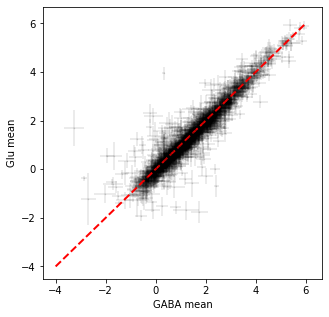

In [113]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))
ax1.errorbar(mean_vals[0,:,:].mean(0),mean_vals[1,:,:].mean(0),
                 mean_vals[0,:,:].std(0),mean_vals[1,:,:].std(0),'k.',alpha=0.1,markersize=1)
# # 

xl = [-4,6]
plt.plot(xl,xl,'r--',linewidth=2)
plt.xlabel('GABA mean')
plt.ylabel('Glu mean')

In [114]:
p_mean = np.zeros(n_genes)
for i in range(n_genes):
    p_mean[i] = scipy.stats.ttest_ind(mean_vals[0,:,i],mean_vals[1,:,i],equal_var=False)[1]

Text(0.5, 0, '$\\mu$ fold change across 4 datasets')

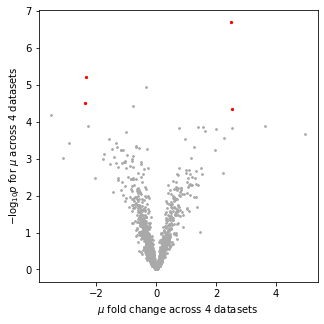

In [115]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

fc_mean = (mean_vals[1,:,:]-mean_vals[0,:,:]).mean(0)
gf_pval = p_mean<pval_thr

gf_fc = np.abs(fc_mean)>1

gf = gf_pval & gf_fc

logp_mean = -np.log10(p_mean)
ax1.scatter(fc_mean[gf],logp_mean[gf],color='r',s=5)
ax1.scatter(fc_mean[~gf],logp_mean[~gf],color='darkgray',s=3)
ax1.set_ylabel(r'$-\log_{10} p$ for $\mu$ across 4 datasets')
ax1.set_xlabel(r'$\mu$ fold change across 4 datasets')


In [116]:
print(gn[gf])

['Dner' 'Pamr1' 'Rell1' 'Sv2c']


## Differential regulation testing with biological replicates

Inspect the fit parameter values. We observe offsets and hypothesize these are due to imprecision in the sampling parameter fits.

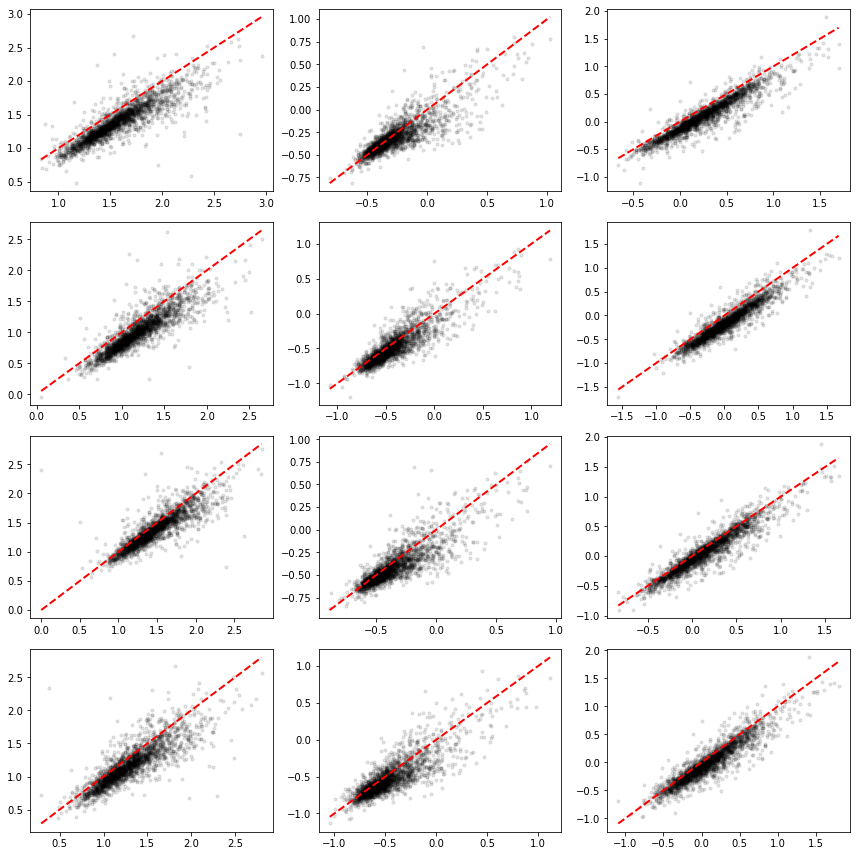

In [117]:
fig1,ax1 = plt.subplots(n_datasets,n_phys_pars,figsize=(12,12))
for d in range(n_datasets):
    for k in range(n_phys_pars):
        x=par_vals_uncorrected[0,d,:,k]
        y=par_vals_uncorrected[1,d,:,k]
        xl = [min(x),max(x)]
        ax1[d,k].scatter(x,y,10,'k',alpha=0.1) 

        ax1[d,k].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [118]:
offsets = []
par_vals = np.copy(par_vals_uncorrected)
for k in range(n_phys_pars):
    m1 = par_vals_uncorrected[0,0,:,k]
    for j in range(1,n_datasets):
        m2 = par_vals_uncorrected[0,j,:,k]
        offset = diffreg_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[0,j,:,k] -= offset
    for j in range(n_datasets):
        m2 = par_vals_uncorrected[1,j,:,k]
        offset = diffreg_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[1,j,:,k] -= offset
    
    

Inspect the fit parameter values after correction.

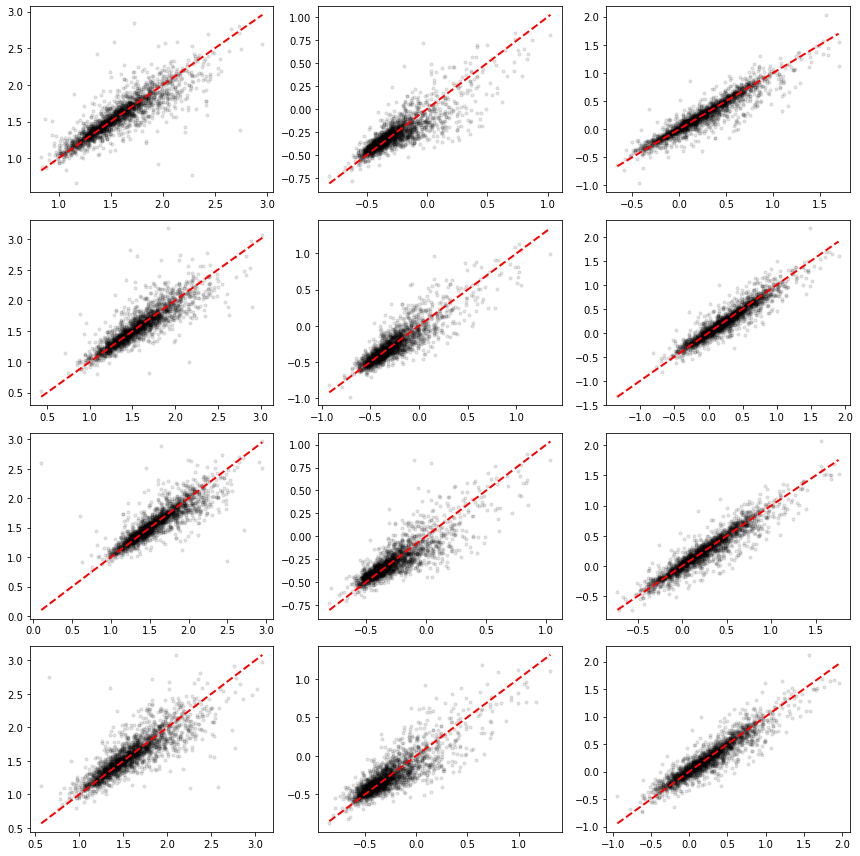

In [119]:
fig1,ax1 = plt.subplots(n_datasets,n_phys_pars,figsize=(12,12))
for d in range(n_datasets):
    for k in range(n_phys_pars):
        x=par_vals[0,d,:,k]
        y=par_vals[1,d,:,k]
        xl = [min(x),max(x)]
        ax1[d,k].scatter(x,y,10,'k',alpha=0.1) 

        ax1[d,k].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

Plot average and standard deviation across four datasets.

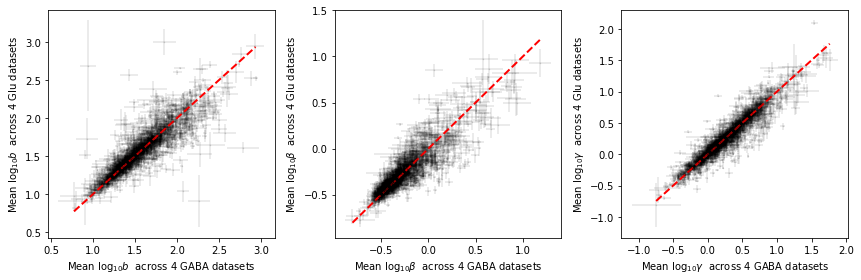

In [120]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
p =  []
for k in range(n_phys_pars):
    x=par_vals[0,:,:,k].mean(0)
    y=par_vals[1,:,:,k].mean(0)
    xl = [min(x),max(x)]
    ax1[k].errorbar(x,y,
                     par_vals[0,:,:,k].std(0),par_vals[1,:,:,k].std(0),'k.',alpha=0.1,markersize=1) 
    
    ax1[k].plot(xl,xl,'r--',linewidth=2)
    ax1[k].set_xlabel(r'Mean '+param_names[k]+'  across 4 GABA datasets')
    ax1[k].set_ylabel(r'Mean '+param_names[k]+'  across 4 Glu datasets')
fig1.tight_layout()

In [121]:
p_par = np.zeros((n_genes,n_phys_pars))
for k in range(n_phys_pars):
    for j in range(n_genes):
        p_par[j,k] = scipy.stats.ttest_ind(par_vals[0,:,j,k],par_vals[1,:,j,k],equal_var=False)[1]
    

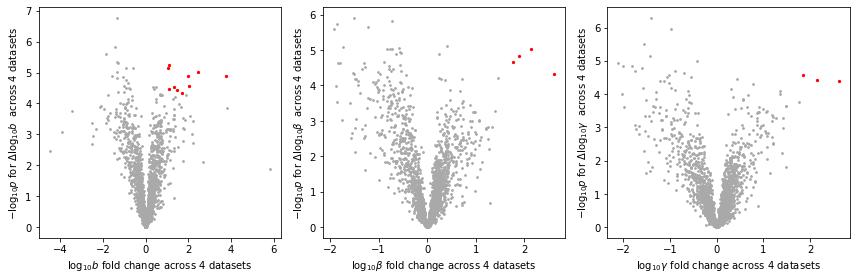

In [136]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
fc_par = ((par_vals[1,:,:,:]-par_vals[0,:,:,:])/np.log10(2)).mean(0)
gf_par = np.zeros((n_genes,n_phys_pars),dtype=bool)
for k in range(n_phys_pars):
    fc_d = fc_parval[:,k]
    gf_pval = p_par[:,k]<pval_thr
    
    gf_fc = fc_d>1
    gf = gf_pval & gf_fc
    
    gf_par[:,k] = gf
    
    logp_par = -np.log10(p_par[:,k])
    ax1[k].scatter(fc_d[gf],logp_par[gf],color='r',s=5)
    ax1[k].scatter(fc_d[~gf],logp_par[~gf],color='darkgray',s=3)
    ax1[k].set_ylabel(r'$-\log_{10} p$ for $\Delta$'+param_names[k]+'  across 4 datasets')
    ax1[k].set_xlabel(param_names[k]+' fold change across 4 datasets')
fig1.tight_layout()

In [137]:
for k in range(n_phys_pars):
    print(gn[gf_par[:,k]])

['Extl3' 'Garnl3' 'Lpgat1' 'Ndst1' 'Nhsl2' 'Prkce' 'Sdk2' 'Sec62' 'Srgap3'
 'Tle4']
['A230006K03Rik' 'Camk2d' 'Nav1' 'Srgap3']
['A230006K03Rik' 'Camk2d' 'Nav1']


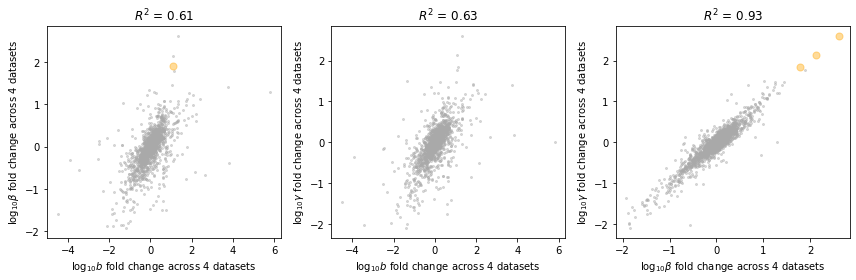

In [140]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[0,1],[0,2],[1,2]]
q=0
for pair in pairs:
    k1 = pair[0]
    k2 = pair[1]
    gf = gf_par[:,k1] & gf_par[:,k2]
    
    x = fc_parval[:,k1]
    y = fc_parval[:,k2]
    
    ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
    ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
    ax1[q].set_xlabel(param_names[k1]+' fold change across 4 datasets')
    ax1[q].set_ylabel(param_names[k2]+' fold change across 4 datasets')
    xl = [fc_parval[:,1].min(),fc_parval[:,1].max()]
    cc = np.corrcoef(x,y)[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    q+=1
fig1.tight_layout()

## Differential regulation testing within a replicate

INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/pair_parameter_comparison_B08.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/pair_parameter_comparison_C01.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/pair_parameter_comparison_F08.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/pair_parameter_comparison_H12.png.


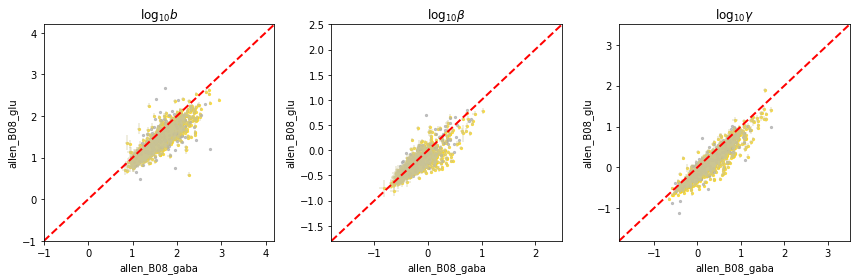

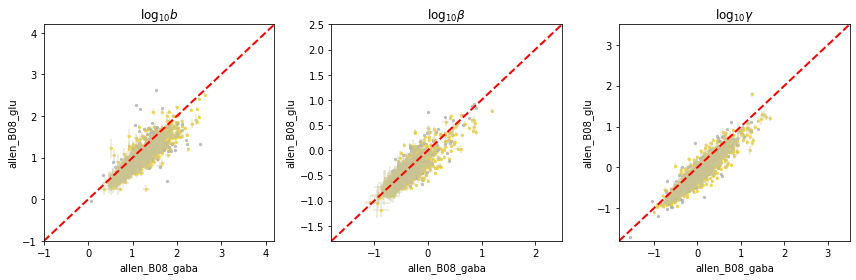

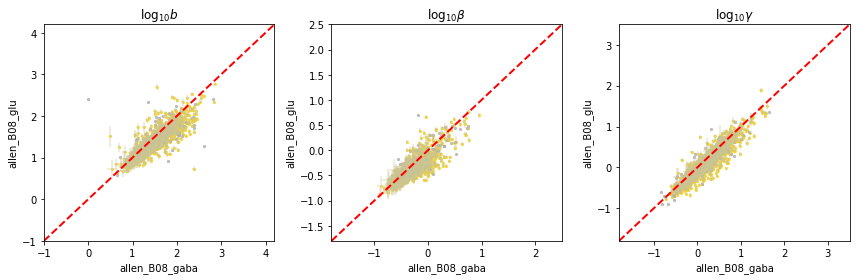

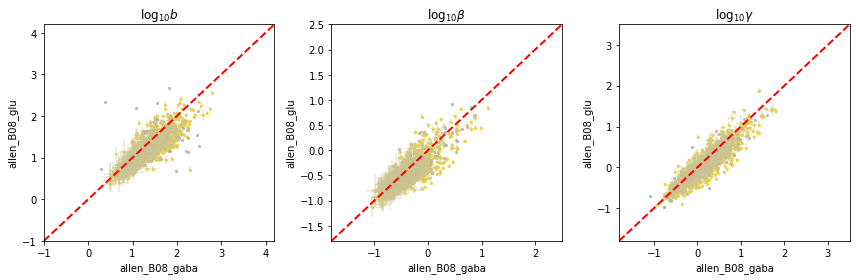

In [145]:
for j in range(n_datasets):
    plot_params_for_pair(sr_arr_gaba[j],sr_arr_glu[j],\
                         distinguish_rej=True,plot_errorbars=True,meta = dataset_meta[j],xlabel = dataset_names[i*2],\
                         ylabel = dataset_names[i*2+1])

INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/mean_comparison_s.png.


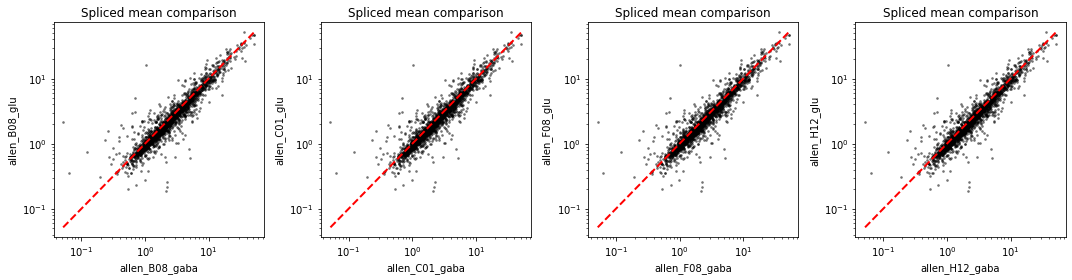

In [150]:
fig1,ax1= plt.subplots(1,n_datasets,figsize=(15,4))
for i in range(n_datasets):
    m1 = [sd_arr_gaba[j].moments[x]['S_mean']  for x in range(n_genes)]
    m2 = [sd_arr_glu[j].moments[x]['S_mean'] for x in range(n_genes)]
    ax1[i].scatter(m1,m2,3,'k',alpha=0.4)
    ax1[i].set_xscale('log')
    ax1[i].set_yscale('log')
    ax1[i].set_xlabel(dataset_names[i*2])
    ax1[i].set_ylabel(dataset_names[i*2+1])
    ax1[i].set_title('Spliced mean comparison')
    xl = [min(m1),max(m1)]
    ax1[i].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()
fig_string = sr_arr_gaba[0].batch_analysis_string+'/mean_comparison_s.png'
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))


In [358]:
# fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

# gf = p_par<pval_thr

# logp_mean = -np.log10(p_mean)
# ax1.scatter(fc_mean[gf],logp_mean[gf],color='r',s=5)
# ax1.scatter(fc_mean[~gf],logp_mean[~gf],color='darkgray',s=3)
# ax1.set_ylabel(r'$-\log_{10} p$ for $\Delta\mu$ across 4 datasets')
# ax1.set_xlabel(r'$\Delta\mu$ fold change across 4 datasets')


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2130 but corresponding boolean dimension is 3

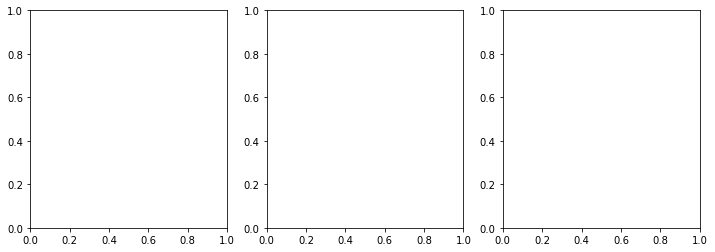

In [135]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
fc_parval = ((par_vals[1,:,:,:]-par_vals[0,:,:,:])/np.log10(2)).mean(0)
gf_par = []
for i in range(n_phys_pars):
#     fc_d = (par_vals[1,:,:,i]-par_vals[0,:,:,i]).mean(0)
    fc_d = fc_parval[:,i]
    gf = p_par[i]<pval_thr
    
    logp_par = -np.log10(p_par[i])
    ax1[i].scatter(fc_d[gf],logp_par[gf],color='r',s=5)
    ax1[i].scatter(fc_d[~gf],logp_par[~gf],color='darkgray',s=3)
    gf_par.append(gf)
    ax1[i].set_ylabel(r'$-\log_{10} p$ for $\Delta$'+param_names[i]+'  across 4 datasets')
    ax1[i].set_xlabel(param_names[i]+' fold change across 4 datasets')

gf_par = np.asarray(gf_par)

Modulation of frequency seems to be ubiquitous, but rarely identified by $t$-test.

In [566]:
k = gf_par[1] & gf_par[2]
k.sum()

13

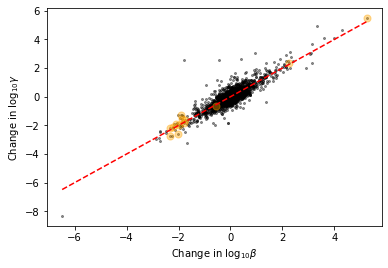

In [567]:
plt.scatter(fc_parval[:,1],fc_parval[:,2],4,'k',alpha=0.4)
plt.scatter(fc_parval[k,1],fc_parval[k,2],50,'orange',alpha=0.4)
plt.xlabel('Change in '+param_names[1])
plt.ylabel('Change in '+param_names[2])
xl = [fc_parval[:,1].min(),fc_parval[:,1].max()]
plt.plot(xl,xl,'r--')

Text(0, 0.5, 'Change in $\\log_{10} \\gamma$')

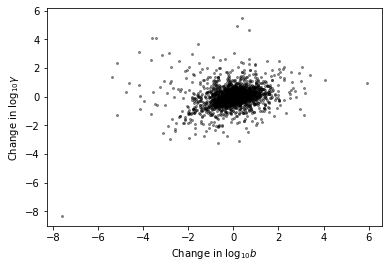

In [568]:
plt.scatter(fc_parval[:,0],fc_parval[:,2],4,'k',alpha=0.4)
plt.xlabel('Change in '+param_names[0])
plt.ylabel('Change in '+param_names[2])

Text(0, 0.5, 'Change in $\\log_{10} \\beta$')

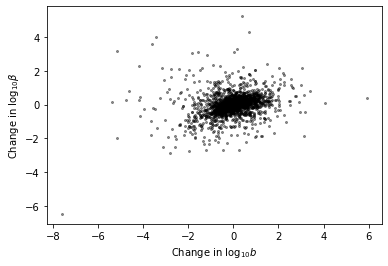

In [569]:
plt.scatter(fc_parval[:,0],fc_parval[:,1],4,'k',alpha=0.4)
plt.xlabel('Change in '+param_names[0])
plt.ylabel('Change in '+param_names[1])

In [570]:
b = gf_par[0]

In [571]:
print(b.sum())
gn[b]

78


array(['Klhl3', 'Thra', 'Prkcb', 'Nek7', 'Rnf165', 'Atp2b4', 'Daam1',
       'Atf6', 'Mpped1', 'Angpt1', 'Gpm6b', 'Stx1a', 'Tmem130', 'Galnt18',
       'Rbms3', 'Stum', 'Bhlhb9', 'Gabra1', '2900026A02Rik', 'Inpp5f',
       'Cacna2d2', 'Ece1', 'Dtnb', 'Mmd', 'Kcnn2', 'Tmem44', 'Klf9',
       'Klf5', 'Ppp1r9a', 'Dgkb', 'Diras2', 'Arhgef9', 'Nectin1', 'Sv2c',
       'Cadps2', 'Synpr', 'Nwd2', 'Phka2', 'Wasf1', 'Nfix', 'Lingo1',
       'Ubr5', 'Bend6', 'Igsf9b', 'Slc9a6', 'Parm1', 'Ndst1', 'Dlg1',
       'Tox3', 'Cers6', 'Foxp1', 'Adcy2', 'Grip2', 'Pgm2l1', 'Dpysl3',
       'Dlc1', 'Slco3a1', 'Camk2a', 'Tpm3', 'Actn4', 'Cnksr2', 'Igsf21',
       'Arnt2', 'Enah', 'Xkr6', '2010300C02Rik', 'Hunk', 'Rrbp1',
       'Tnfaip8l3', 'Arhgap32', 'Dlgap4', 'Ube2e2', 'Glce', 'Fstl5',
       'Cald1', 'Prkacb', 'Rims4', 'Serpine2'], dtype='<U16')

In [572]:
print(k.sum())
gn[k]

13


array(['Galnt18', 'Gabrd', 'Cacna2d1', 'Cdh6', 'Ramp1', 'A530058N18Rik',
       'Ptprk', 'Adcy2', 'Galnt14', 'Camk1d', 'Mpped2', 'Fam135b',
       'Sorcs1'], dtype='<U16')

In [573]:
print(gf_ttest.sum())
print(gn[gf_ttest])

164
['Klhl3' 'Elavl2' 'Gad2' 'Prkcb' 'Atp2b4' 'Kcnb1' 'Dclk1' 'Pcsk2' 'Gpm6b'
 'R3hdm1' 'Camkk2' 'Stx1a' 'Tmem130' 'Reln' 'Rbms3' 'Arf3' 'Dlg4' 'Fut9'
 'Cap2' 'Khdrbs3' '2900026A02Rik' 'Pkig' 'Inpp5f' 'Adgrb1' 'Dgkz' 'Plec'
 'Sorl1' 'Pak1' 'Mmd' 'Rbfox3' 'Arpp21' 'Ngef' 'Klf9' 'Acvr1c' 'Gfra2'
 'Ppp1r9a' 'Sirpa' 'Rap1gap2' 'Sort1' 'Qk' 'Sorbs2' 'Cacna2d1' 'Diras2'
 'Arhgef9' 'Igf1' 'Galnt9' 'Cadps2' 'Synpr' 'Tspan13' 'Hlf' 'Ssbp3' 'Dner'
 'Rab3c' 'Scn8a' 'Cabp1' 'Cyfip2' 'Gda' 'Wasf1' 'Lingo1' 'Phf24' 'Mtpn'
 'Itpr1' 'Igsf9b' 'Cx3cl1' 'Ap1s2' 'Cxxc5' 'Maf' 'Parm1' 'Dgkh' 'Lzts1'
 'Dlg1' 'Grin3a' 'Slc39a10' 'Rasgef1a' 'Dlx6os1' 'Inpp4a' 'Pip5k1c'
 'Pik3r1' 'Hivep2' 'Basp1' 'Camk2g' 'Sipa1l1' 'Ryr2' 'Dmtn' 'Foxp1' 'Chn1'
 'Rab3b' 'Brk1' 'Atp2b2' 'Slc8a2' 'Epha4' '5330434G04Rik' 'Ptn' 'Syn1'
 'Pgm2l1' 'Klf7' 'Ano3' 'Camk2a' 'Syt7' 'Pmepa1' 'Map2k1' 'Tcf4' 'Zbtb20'
 'Adcyap1r1' 'Chrm1' 'Skil' 'Kcnip1' 'Btbd8' 'Actn4' 'Gls' 'Abat' 'Bsn'
 'Nlk' 'Cnksr2' 'Kit' 'Hecw1' 'Ubash3b' 'Klf13' '20103

In [574]:
gf = gf_ttest & gf_par.any(0) 
print(gf.sum())
print(gn[gf])

49
['Klhl3' 'Prkcb' 'Atp2b4' 'Gpm6b' 'Stx1a' 'Tmem130' 'Rbms3'
 '2900026A02Rik' 'Inpp5f' 'Mmd' 'Arpp21' 'Klf9' 'Acvr1c' 'Ppp1r9a'
 'Cacna2d1' 'Diras2' 'Arhgef9' 'Igf1' 'Cadps2' 'Synpr' 'Wasf1' 'Lingo1'
 'Igsf9b' 'Cxxc5' 'Parm1' 'Lzts1' 'Dlg1' 'Hivep2' 'Foxp1' '5330434G04Rik'
 'Pgm2l1' 'Ano3' 'Camk2a' 'Adcyap1r1' 'Actn4' 'Abat' 'Cnksr2' 'Ubash3b'
 '2010300C02Rik' 'Rasgrp1' 'Arhgap32' 'Spock3' 'Camk1d' 'C530008M17Rik'
 'Fam81a' 'Fam135b' 'Mtss1' 'Igsf3' 'Mical2']


In [575]:
gf = ~gf_ttest & gf_par.any(0) 
print(gf.sum())
print(gn[gf])

95
['Thra' 'Nek7' 'Rnf165' 'Il34' 'Daam1' 'Atf6' 'Mpped1' 'Angpt1' 'Galnt18'
 'Stum' 'Bhlhb9' 'Gabra1' 'Nav1' 'Cacna2d2' 'Camk2d' 'Ece1' 'Dtnb' 'Kcnn2'
 'Tmem44' 'Klf5' 'Rims3' 'Dgkb' 'Trhde' 'Gabrd' 'Nectin1' 'Sv2c' 'Nwd2'
 'Thsd7a' 'Phka2' 'Nfix' 'Ubr5' 'Bend6' 'Plcl2' 'Tnr' 'Cdh6' 'Slc9a6'
 'Ndst1' 'Rcan2' 'Tox3' 'Runx1t1' 'Ramp1' 'Osbpl9' 'Stmn3' 'Syndig1'
 'A530058N18Rik' 'Cers6' 'Ptprk' 'Mgat3' 'A230006K03Rik' 'Csnk1a1' 'Adcy2'
 'Grip2' 'Dpysl3' 'Dlc1' 'Slco3a1' 'Cep83' 'Chd9' 'Dzank1' 'Tpm3' 'Crtc3'
 'Igsf21' 'Cntfr' 'Drp2' 'Srgap3' 'Arnt2' 'Enah' 'Xkr6' 'Nyap2' 'Fnbp1l'
 '1110004F10Rik' 'Hunk' 'Galnt14' 'Rrbp1' 'Cacng5' 'Tmem178b' 'Tnfaip8l3'
 'Hdac4' 'Dlgap4' 'Cbln2' 'Col25a1' 'Wwc2' 'Mpped2' 'Ube2e2' 'Glce'
 'Baz2b' 'Prickle1' 'Sorcs1' 'Scg3' 'Fstl5' 'Rcan3' 'Cald1' 'Prkacb'
 'Rims4' 'Serpine2' 'Mblac2']


In [576]:
gf = gf_ttest & ~gf_par.any(0) 
print(gf.sum())
print(gn[gf])

115
['Elavl2' 'Gad2' 'Kcnb1' 'Dclk1' 'Pcsk2' 'R3hdm1' 'Camkk2' 'Reln' 'Arf3'
 'Dlg4' 'Fut9' 'Cap2' 'Khdrbs3' 'Pkig' 'Adgrb1' 'Dgkz' 'Plec' 'Sorl1'
 'Pak1' 'Rbfox3' 'Ngef' 'Gfra2' 'Sirpa' 'Rap1gap2' 'Sort1' 'Qk' 'Sorbs2'
 'Galnt9' 'Tspan13' 'Hlf' 'Ssbp3' 'Dner' 'Rab3c' 'Scn8a' 'Cabp1' 'Cyfip2'
 'Gda' 'Phf24' 'Mtpn' 'Itpr1' 'Cx3cl1' 'Ap1s2' 'Maf' 'Dgkh' 'Grin3a'
 'Slc39a10' 'Rasgef1a' 'Dlx6os1' 'Inpp4a' 'Pip5k1c' 'Pik3r1' 'Basp1'
 'Camk2g' 'Sipa1l1' 'Ryr2' 'Dmtn' 'Chn1' 'Rab3b' 'Brk1' 'Atp2b2' 'Slc8a2'
 'Epha4' 'Ptn' 'Syn1' 'Klf7' 'Syt7' 'Pmepa1' 'Map2k1' 'Tcf4' 'Zbtb20'
 'Chrm1' 'Skil' 'Kcnip1' 'Btbd8' 'Gls' 'Bsn' 'Nlk' 'Kit' 'Hecw1' 'Klf13'
 'Efna5' 'Trim9' 'Nol4' 'Rorb' 'St3gal5' 'Slc6a1' 'Afap1' 'Fam131a'
 'R3hdm2' 'Ptk2b' 'Sema3c' 'Csmd2' 'Klhl2' 'Ldb2' 'Adgrl2' 'Hmgcr' 'Nr4a1'
 'Frrs1l' 'Psd3' 'Snca' 'Spred1' 'Sv2b' 'Mast3' 'Gm17167' 'Fmnl1' 'Mras'
 'Ncan' 'Kctd1' 'Arap2' 'Syne1' 'Hapln1' 'Fat3' 'Clstn1' 'Cacna1e'
 'St6gal2']


In [577]:
dataset_names

['allen_A08_gaba',
 'allen_A08_glu',
 'allen_B01_gaba',
 'allen_B01_glu',
 'allen_B08_gaba',
 'allen_B08_glu',
 'allen_C01_gaba',
 'allen_C01_glu']

## Qualitative investigations.

The mean and variance of means do not appear to have a strong relationship.

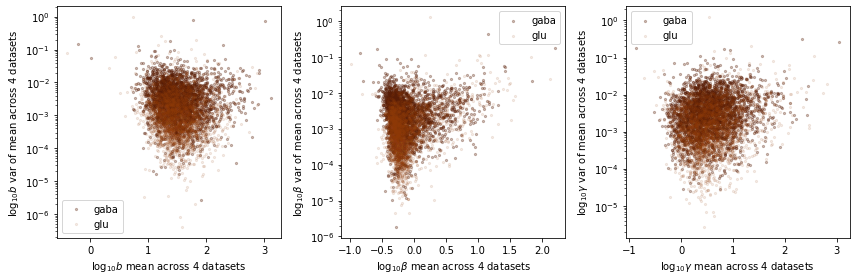

In [578]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
for i in range(n_phys_pars):
    x = par_vals[0,:,:,i].mean(0)
    y = par_vals[0,:,:,i].var(0)
    ax1[i].scatter(x,y,5,Degas[0],alpha=0.3,label='gaba')
    
    x = par_vals[1,:,:,i].mean(0)
    y = par_vals[1,:,:,i].var(0)
    ax1[i].scatter(x,y,5,Degas[1],alpha=0.1,label='glu')
    
    
    ax1[i].set_xlabel(param_names[i]+' mean across 4 datasets')
    ax1[i].set_yscale('log')
    ax1[i].set_ylabel(param_names[i]+' var of mean across 4 datasets')
    ax1[i].legend()
fig1.tight_layout()


What if we just pool the variance by squaring the estimated SEM and adding their values across datasets?

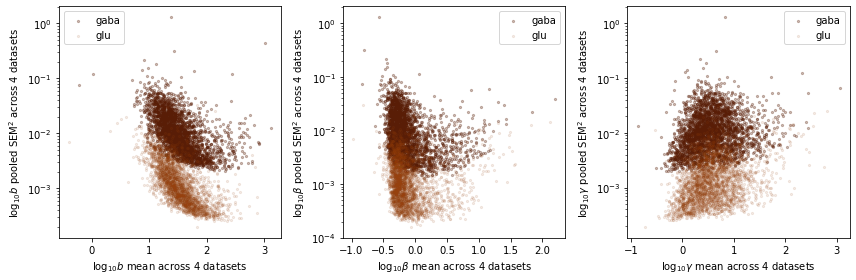

In [579]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
for i in range(n_phys_pars):
    x = par_vals[0,:,:,i].mean(0)
    y = (sigma_vals[0,:,:,i]**2).sum(0)
    ax1[i].scatter(x,y,5,Degas[0],alpha=0.3,label='gaba')
    
    x = par_vals[1,:,:,i].mean(0)
    y = (sigma_vals[1,:,:,i]**2).sum(0)
    ax1[i].scatter(x,y,5,Degas[1],alpha=0.1,label='glu')
    
    
    ax1[i].set_xlabel(param_names[i]+' mean across 4 datasets')
    ax1[i].set_yscale('log')
    ax1[i].set_ylabel(param_names[i]+r' pooled SEM$^2$ across 4 datasets')
    ax1[i].legend()
fig1.tight_layout()


## Parameter correlation between replicates, for the same cell type

In [580]:
dataset_names

['allen_A08_gaba',
 'allen_A08_glu',
 'allen_B01_gaba',
 'allen_B01_glu',
 'allen_B08_gaba',
 'allen_B08_glu',
 'allen_C01_gaba',
 'allen_C01_glu']

### burst size

Note the higher correlation between technical replicates (C01/B01 and A08/B08). GABAergic in bottom left, glutamatergic in top right.

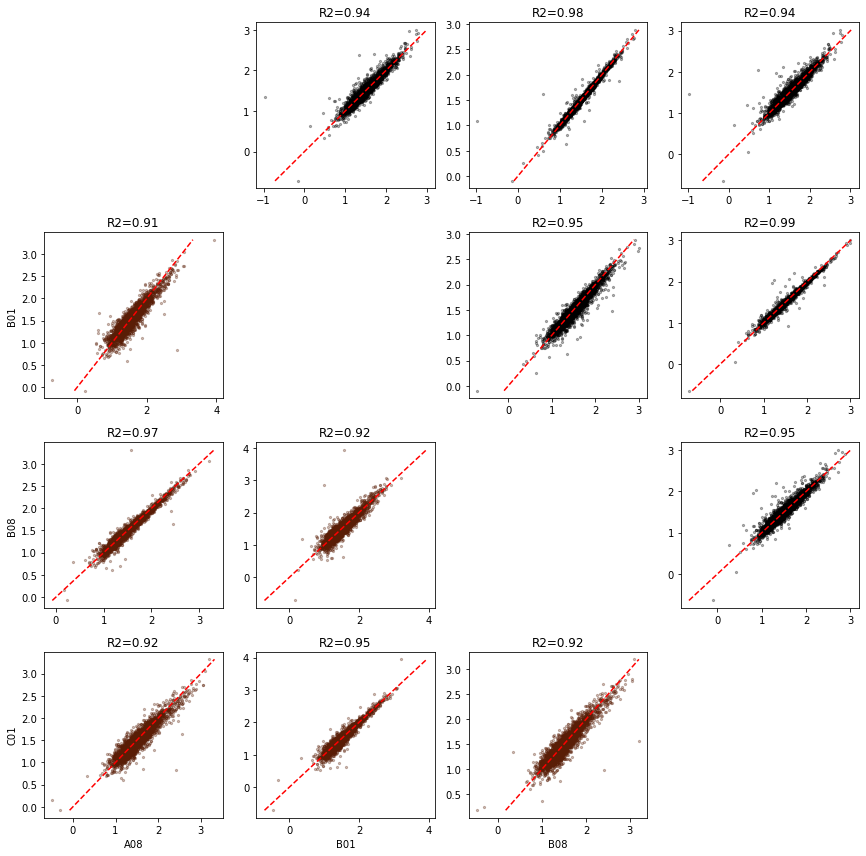

In [549]:
fig1,ax1 = plt.subplots(4,4,figsize=(12,12))
k=0
for i in range(4):
    for j in range(4):
        if i != j:
            if i>j:
                x = par_vals[0,i,:,k]
                y = par_vals[0,j,:,k]
                ax1[i,j].scatter(x,y,5,Degas[0],alpha=0.3,label='gaba')
                xl = (min(y),max(y))
                ax1[i,j].plot(xl,xl,'r--')
            elif i<j:
                x = par_vals[1,i,:,k]
                y = par_vals[1,j,:,k]
                ax1[i,j].scatter(x,y,5,'k',alpha=0.3,label='glu')
                xl = (min(y),max(y))
                ax1[i,j].plot(xl,xl,'r--')
            if j==0:
                ax1[i,j].set_ylabel(dataset_meta[i])
            if i==3:
                ax1[i,j].set_xlabel(dataset_meta[j])
            cc = np.corrcoef(x,y)[0,1]
            ax1[i,j].set_title('R2={:.2f}'.format(cc))
        else: 
            fig1.delaxes(ax1[i,j])
fig1.tight_layout()


### Splicing rate

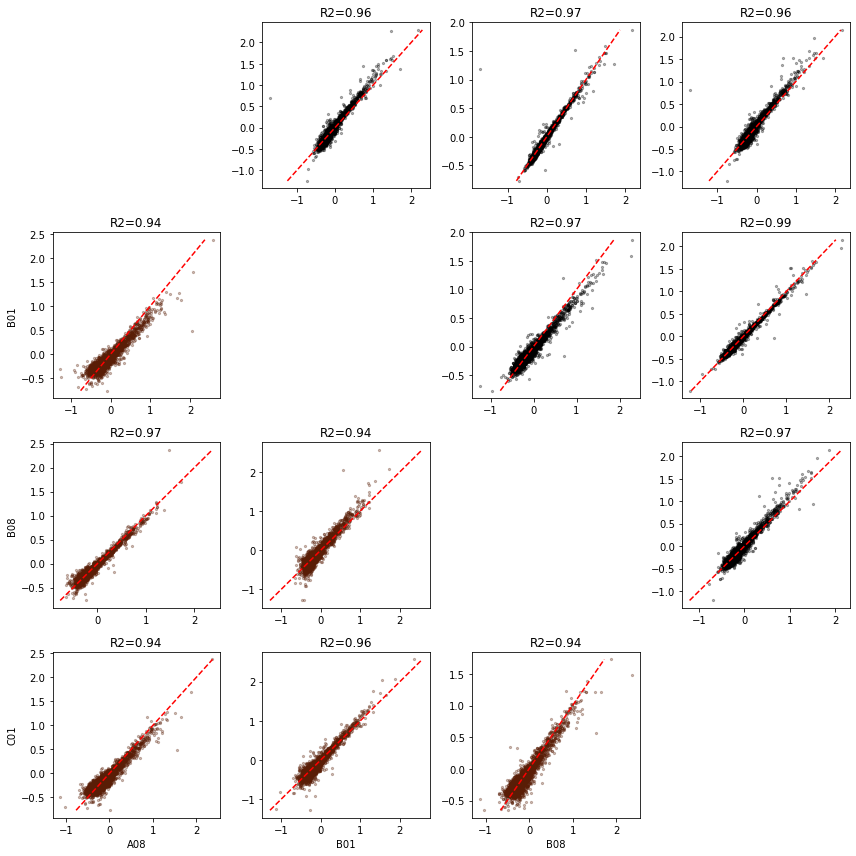

In [550]:
fig1,ax1 = plt.subplots(4,4,figsize=(12,12))
k=1
for i in range(4):
    for j in range(4):
        if i != j:
            if i>j:
                x = par_vals[0,i,:,k]
                y = par_vals[0,j,:,k]
                ax1[i,j].scatter(x,y,5,Degas[0],alpha=0.3,label='gaba')
                xl = (min(y),max(y))
                ax1[i,j].plot(xl,xl,'r--')
            elif i<j:
                x = par_vals[1,i,:,k]
                y = par_vals[1,j,:,k]
                ax1[i,j].scatter(x,y,5,'k',alpha=0.3,label='glu')
                xl = (min(y),max(y))
                ax1[i,j].plot(xl,xl,'r--')
            if j==0:
                ax1[i,j].set_ylabel(dataset_meta[i])
            if i==3:
                ax1[i,j].set_xlabel(dataset_meta[j])
            cc = np.corrcoef(x,y)[0,1]
            ax1[i,j].set_title('R2={:.2f}'.format(cc))
        else: 
            fig1.delaxes(ax1[i,j])
fig1.tight_layout()


### Degradation rate

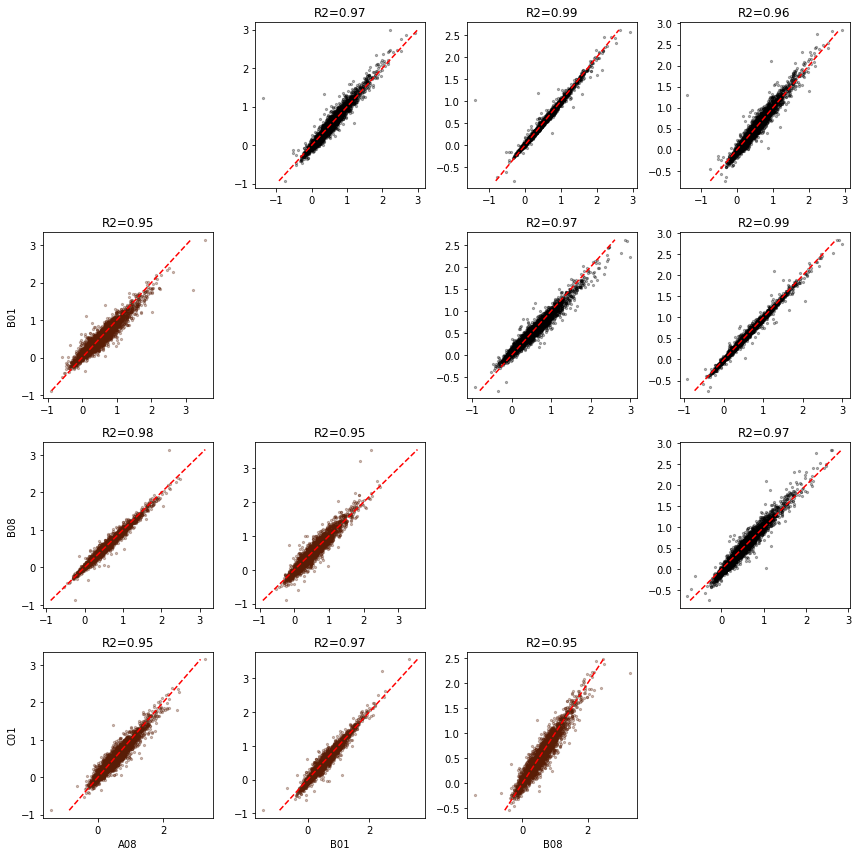

In [551]:
fig1,ax1 = plt.subplots(4,4,figsize=(12,12))
k=2
for i in range(4):
    for j in range(4):
        if i != j:
            if i>j:
                x = par_vals[0,i,:,k]
                y = par_vals[0,j,:,k]
                ax1[i,j].scatter(x,y,5,Degas[0],alpha=0.3,label='gaba')
                xl = (min(y),max(y))
                ax1[i,j].plot(xl,xl,'r--')
            elif i<j:
                x = par_vals[1,i,:,k]
                y = par_vals[1,j,:,k]
                ax1[i,j].scatter(x,y,5,'k',alpha=0.3,label='glu')
                xl = (min(y),max(y))
                ax1[i,j].plot(xl,xl,'r--')
            if j==0:
                ax1[i,j].set_ylabel(dataset_meta[i])
            if i==3:
                ax1[i,j].set_xlabel(dataset_meta[j])
            cc = np.corrcoef(x,y)[0,1]
            ax1[i,j].set_title('R2={:.2f}'.format(cc))
        else: 
            fig1.delaxes(ax1[i,j])
fig1.tight_layout()
